<a href="https://colab.research.google.com/github/amirezzati/Reviews-Sentiment-Analysis/blob/main/Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries & Constants**

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Conv2D, MaxPool2D, Embedding, Reshape, Flatten, LSTM, GRU, SimpleRNN, Concatenate, concatenate, RepeatVector, TimeDistributed, Bidirectional
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences #from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
import seaborn as sb
from scipy import sparse
from scipy.sparse import csr_matrix
import os
import string
from google.colab import drive
import json
import pickle

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.porter import PorterStemmer
import spacy
import nltk
nltk.download('stopwords')
import re
# from transformers import AutoTokenizer, BertTokenizer, TFBertModel

import copy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load Dataset and declare paths**

In [ ]:
drive.mount('/content/drive')
basePath = '/content/drive/MyDrive/AI Projects/Sentiment-Analysis/'
dataPath = basePath + 'amazon_reviews_us_Watches_v1_00.csv'

Mounted at /content/drive


# **Preprocessing**

## **Tokenization, Stemming, Removing Stop words and Punctuation**

In [ ]:
dataset = pd.read_csv(dataPath)

<ipython-input-4-5118f10c515a>:1: DtypeWarning: Columns (17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(dataPath)


In [ ]:
useless_features = ['review_date', 'verified_purchase'] + list(dataset.columns[8:11]) + list(dataset.columns[0:7]) + list(dataset.columns[-7:])
print(useless_features)

dataset.drop(columns=useless_features, inplace=True)
# delete rows with nan elements
dataset = dataset.dropna()

['review_date', 'verified_purchase', 'helpful_votes', 'total_votes', 'vine', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']


In [ ]:
review_headline = np.array(dataset['review_headline'])
review_body = np.array(dataset['review_body'])
star_rating = np.array(dataset['star_rating'])
rev_class = np.empty_like(star_rating)

for i  in range(len(rev_class)):
  if star_rating[i] >= 4:
    rev_class[i] = 1  # class1 : Pos Class
  elif star_rating[i] <= 2:
    rev_class[i] = 2  # class2 : Neg class
  elif star_rating[i] == 3:
    rev_class[i] = 3  # class3 : Neutral class

dataset['rev_class'] = rev_class

dataset.head()

,star_rating,review_headline,review_body,rev_class
0,5,Five Stars,Absolutely love this watch! Get compliments al...,1
1,5,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,1
2,2,Two Stars,Scratches,2
3,5,Five Stars,"It works well on me. However, I found cheaper ...",1
4,4,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,1


In [ ]:
rev_class.shape

(960082,)

In [ ]:
def w_tokenizer(text):
  tokenizer = WhitespaceTokenizer()
  tokenized_list = tokenizer.tokenize(text)
  return tokenized_list

def stemmer_porter(text_list):
  porter = PorterStemmer()
  return_list = []
  for i in range(len(text_list)):
      return_list.append(porter.stem(text_list[i]))
  return(return_list)


def remove_stopwords(text_list):
  NLTK_stopwords = nltk.corpus.stopwords.words('english')
  return_list = []
  for i in range(len(text_list)):
      if text_list[i] not in NLTK_stopwords:
          return_list.append(text_list[i])
  return return_list

def remove_punc(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        return_list = []
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            temp_text = re.sub('[0-9][0-9]+', '', temp_text.lower())
            temp_text = re.sub('\bbr\b', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

def preprocess_sentence(sentence):
  return remove_stopwords(stemmer_porter(remove_punc(w_tokenizer(sentence))))

In [ ]:
with tf.device('/GPU:0'):
  preprocessed_review_headline = [preprocess_sentence(x) for x in review_headline]
  preprocessed_review_body = [preprocess_sentence(x) for x in review_body]

preprocessed_review_headline_length = len(preprocessed_review_headline)
preprocessed_review_body_length = len(preprocessed_review_body)

In [ ]:
print(review_headline[484344])
print(preprocess_sentence(review_headline[484344]))

In [ ]:
# Tfidf Vectorizer (convert tokens to vector)
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word', stop_words=None, lowercase=False, max_features=10000) #, token_pattern='(\d{0,2}[a-zA-Z]+\d{0,2}[a-zA-Z]*$)'
review_vector = vectorizer.fit_transform(preprocessed_review_headline + preprocessed_review_body)

sparse.save_npz(basePath + "review_vector_csr_matrix.npz", review_vector)

review_headline_vector = review_vector[:preprocessed_review_headline_length]
review_body_vector = review_vector[preprocessed_review_headline_length:]

In [ ]:
tfidf_features = vectorizer.get_feature_names_out()
print('number of features in tfidf: ', len(tfidf_features))

In [ ]:
print('review_headline_vector shape: ', review_headline_vector.shape)
print('review_body_vector shape: ', review_body_vector.shape)

In [ ]:
preprocessed_review_headline[:5]

In [ ]:
print(review_headline_vector[0])


## **Load Preprocessed Dataset**

In [ ]:
review_vector = sparse.load_npz(basePath + "review_vector_csr_matrix.npz")

preprocessed_review_headline_length = review_vector.shape[0]//2
review_headline_vector = review_vector[:preprocessed_review_headline_length]
review_body_vector = review_vector[preprocessed_review_headline_length:]
review_class = np.load(basePath + 'review_class.npy')

review_headline_vector.shape, review_body_vector.shape, review_class.shape

((960082, 10000), (960082, 10000), (960082,))

**Splitting Dataset**

In [ ]:
headline_train, headline_test, body_train, body_test, y_train, y_test = train_test_split(review_headline_vector, review_body_vector, review_class, test_size=0.40, random_state=75)
headline_dev, headline_test, body_dev, body_test, y_dev, y_test = train_test_split(headline_test, body_test, y_test, test_size=0.50, random_state=75)

print('train shape: ', headline_train.shape, body_train.shape, y_train.shape)
print('dev shape: ', headline_dev.shape, body_dev.shape, y_dev.shape)
print('test shape: ', headline_test.shape, body_test.shape, y_test.shape)

train shape:  (576049, 10000) (576049, 10000) (576049,)
dev shape:  (192016, 10000) (192016, 10000) (192016,)
test shape:  (192017, 10000) (192017, 10000) (192017,)


In [ ]:
print(headline_train[6])

  (0, 3931)	0.7233393429998286
  (0, 1646)	0.5429914847679976
  (0, 4998)	0.4265447717860598


In [ ]:
# sort sparse matrix
csr_matrix.sort_indices(headline_train)
csr_matrix.sort_indices(headline_dev)
csr_matrix.sort_indices(headline_test)
csr_matrix.sort_indices(body_train)
csr_matrix.sort_indices(body_dev)
csr_matrix.sort_indices(body_test)

In [ ]:
print(headline_train[6])

  (0, 1646)	0.5429914847679976
  (0, 3931)	0.7233393429998286
  (0, 4998)	0.4265447717860598


# **Models**

## **Naive Bayez**

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# horizontal stacking
X_train = sparse.hstack((body_train, headline_train))
X_test = sparse.hstack((body_test, headline_test))

# Build a Gaussian Classifier
model = MultinomialNB(force_alpha=True)

# Model training
model.fit(X_train, y_train)

# Predict Output
print(X_test[6].shape)
predicted = model.predict(X_test[6])

print("Actual Value:", y_test[6])
print("Predicted Value:", predicted[0])

(1, 20000)
Actual Value: 2
Predicted Value: 2


Accuracy: 0.8815573621085633


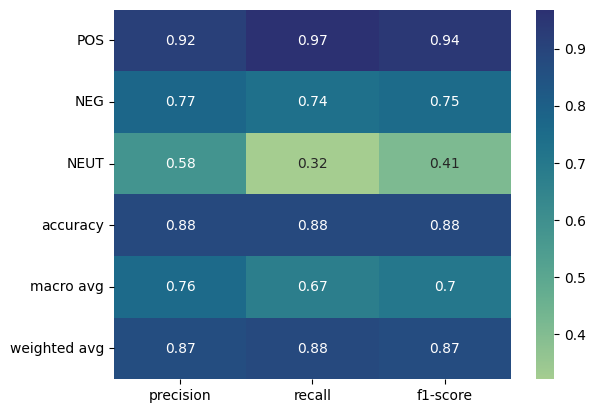

In [ ]:
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)

report = classification_report(y_test, y_pred, target_names=['POS', 'NEG', 'NEUT'], output_dict=True)
sb.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='crest')

print("Accuracy:", accuray)

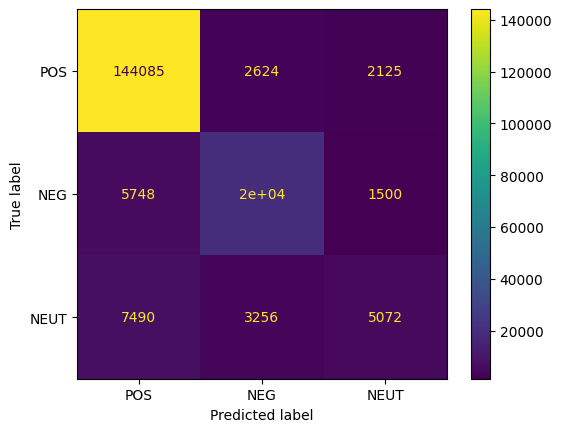

In [ ]:
labels = [1,2,3]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['POS', 'NEG', 'NEUT'])
disp.plot();

## **Neural Network**

In [ ]:
X_train = [headline_train, body_train]
X_dev = [headline_dev, body_dev]
X_test = [headline_test, body_test]


y_train_OH = to_categorical(y_train)[:, 1:4]
y_dev_OH = to_categorical(y_dev)[:, 1:4]
y_test_OH = to_categorical(y_test)[:, 1:4]

validation_data = (X_dev, y_dev_OH)
y_train_OH.shape

(576049, 3)

In [ ]:
def showPlots(history):
  plt.plot(history['accuracy'],
            label='training accuracy', marker='.', color='green')
  plt.plot(history['val_accuracy'],
            label='test accuracy', marker='.', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(history['loss'],
            label='training loss', marker='.', color='green')
  plt.plot(history['val_loss'],
            label='test loss', marker='.', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# function for convert probablity to 0s and 1s for multiple classification
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

In [ ]:
# Functional Model
input1 = Input(shape=X_train[0].shape[1:], sparse=True)
input2 = Input(shape=X_train[1].shape[1:], sparse=True)

d1 = Dense(128, activation='relu')(input1)
d1 = Dropout(0.2)(d1)
d1 = BatchNormalization()(d1)

d2 = Dense(128, activation='relu')(input2)
d2 = Dropout(0.2)(d2)
d2 = BatchNormalization()(d2)

c = Concatenate()([d1, d2])

d = Dense(64, activation='relu')(c)
d = Dropout(0.2)(d)
d = BatchNormalization()(d)

output = Dense(3, activation="softmax")(d)

# Compile the Model
model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer=Adam(0.001), metrics=['accuracy'])

Epoch 1/10
1126/1126 [==============================] - 133s 113ms/step - loss: 0.3180 - accuracy: 0.8845 - val_loss: 0.2700 - val_accuracy: 0.8973
Epoch 2/10
1126/1126 [==============================] - 46s 39ms/step - loss: 0.2432 - accuracy: 0.9077 - val_loss: 0.2580 - val_accuracy: 0.9027
Epoch 3/10
1126/1126 [==============================] - 37s 30ms/step - loss: 0.2118 - accuracy: 0.9187 - val_loss: 0.2658 - val_accuracy: 0.9018
Epoch 4/10
1126/1126 [==============================] - 31s 26ms/step - loss: 0.1799 - accuracy: 0.9313 - val_loss: 0.2849 - val_accuracy: 0.8991
Epoch 5/10
1126/1126 [==============================] - 30s 25ms/step - loss: 0.1515 - accuracy: 0.9423 - val_loss: 0.3148 - val_accuracy: 0.8962
Epoch 6/10
1126/1126 [==============================] - 28s 24ms/step - loss: 0.1284 - accuracy: 0.9514 - val_loss: 0.3443 - val_accuracy: 0.8934
Epoch 7/10
1126/1126 [==============================] - 25s 21ms/step - loss: 0.1124 - accuracy: 0.9578 - val_loss: 0.3674

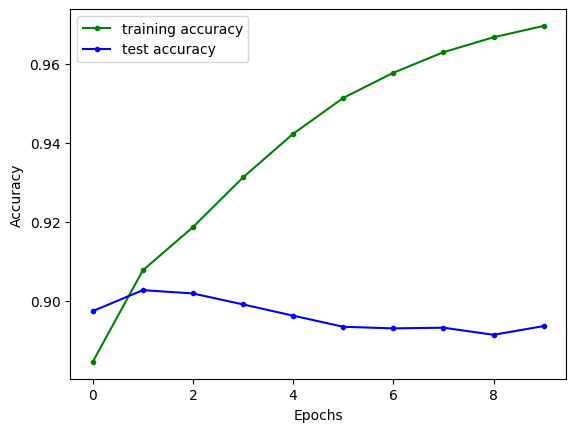

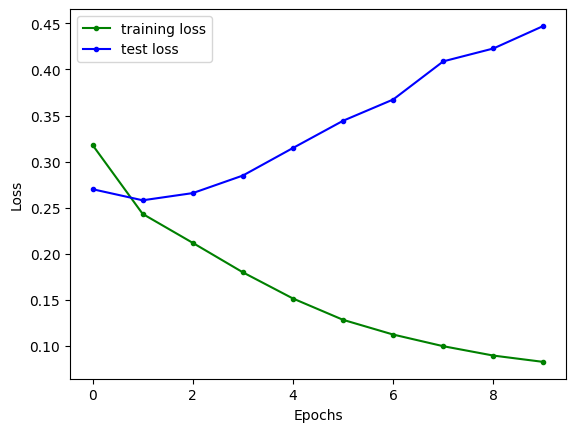

In [ ]:
# train the model
filepath = basePath + 'NN_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train_OH, validation_data=validation_data, epochs=10, batch_size=512, verbose=1, callbacks=[checkpoint]).history

showPlots(history)

In [ ]:
filepath = basePath + 'NN_model.hdf5'
model = load_model(filepath)
with tf.device('/GPU:0'):
  model.evaluate(X_test, y_test_OH, verbose=0)
  y_pred = model.predict(X_test)

Accuracy: 0.9030971216090242


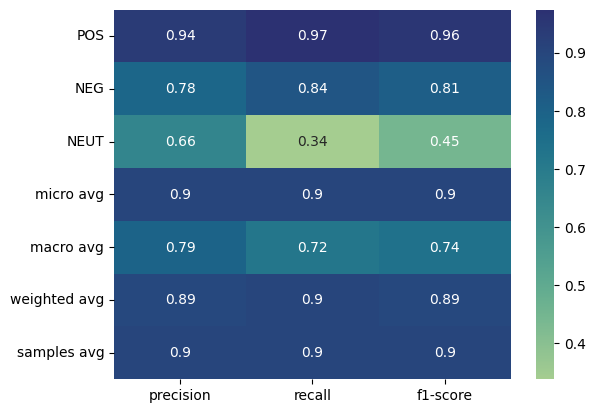

In [ ]:
y_pred_OH = argmaxKeepDimensions(y_pred)
accuray = accuracy_score(y_pred_OH, y_test_OH)

report = classification_report(y_test_OH, y_pred_OH, target_names=['POS', 'NEG', 'NEUT'], output_dict=True)
sb.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='crest')

print("Accuracy:", accuray)

In [ ]:
labels = [0,1,2]
cm = confusion_matrix(np.argmax(y_test_OH, axis=1), np.argmax(y_pred_OH, axis=1), labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['POS', 'NEG', 'NEUT'])
disp.plot();

# **Bert Transfer learning**

## **Preprocessing and Preparing the data**

In [ ]:
def getSampleFromDataset(review_headline, review_body, rev_class, sampleNum=10000):

  pos_indices = np.where(rev_class == 1)[0]
  neg_indices = np.where(rev_class == 2)[0]
  neut_indice = np.where(rev_class == 3)[0]

  np.random.seed(5)
  size = sampleNum//3
  pos_indices = np.random.choice(pos_indices, size=size, replace=False)
  neg_indices = np.random.choice(neg_indices, size=size, replace=False)
  neut_indices = np.random.choice(neut_indice, size=sampleNum-2*size, replace=False)

  sample_indices = np.concatenate([pos_indices, neg_indices, neut_indices], axis=0)

  review_headline_sample = np.take(review_headline, sample_indices)
  review_body_sample = np.take(review_body, sample_indices)
  rev_class_sample = np.take(rev_class, sample_indices)

  # np.save(basePath + 'review_class_sample.npy', rev_class)

  return review_headline_sample, review_body_sample, rev_class_sample

In [ ]:
dataset = pd.read_csv(dataPath)

useless_features = ['review_date', 'verified_purchase'] + list(dataset.columns[8:11]) + list(dataset.columns[0:7]) + list(dataset.columns[-7:])
print(useless_features)

dataset.drop(columns=useless_features, inplace=True)
# delete rows with nan elements
dataset = dataset.dropna()

review_headline = np.array(dataset['review_headline'])
review_body = np.array(dataset['review_body'])
star_rating = np.array(dataset['star_rating'])
rev_class = np.empty_like(star_rating)

for i  in range(len(rev_class)):
  if star_rating[i] >= 4:
    rev_class[i] = 1  # class1 : Pos Class
  elif star_rating[i] <= 2:
    rev_class[i] = 2  # class2 : Neg class
  elif star_rating[i] == 3:
    rev_class[i] = 3  # class3 : Neutral class

dataset['rev_class'] = rev_class

dataset.head()

<ipython-input-17-b43a68fc6044>:1: DtypeWarning: Columns (17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(dataPath)


['review_date', 'verified_purchase', 'helpful_votes', 'total_votes', 'vine', 'marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']


,star_rating,review_headline,review_body,rev_class
0,5,Five Stars,Absolutely love this watch! Get compliments al...,1
1,5,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,1
2,2,Two Stars,Scratches,2
3,5,Five Stars,"It works well on me. However, I found cheaper ...",1
4,4,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,1


In [ ]:
# get samples
review_headline_sample, review_body_sample, rev_class_sample = getSampleFromDataset(review_headline, review_body, rev_class, sampleNum=10000)

review_headline_sample.shape, review_body_sample.shape, rev_class_sample.shape

((10000,), (10000,), (10000,))

In [ ]:
def w_tokenizer(text):
  tokenizer = WhitespaceTokenizer()
  tokenized_list = tokenizer.tokenize(text)
  return tokenized_list

def stemmer_porter(text_list):
  porter = PorterStemmer()
  return_list = []
  for i in range(len(text_list)):
      return_list.append(porter.stem(text_list[i]))
  return(return_list)


def remove_stopwords(text_list):
  NLTK_stopwords = nltk.corpus.stopwords.words('english')
  return_list = []
  for i in range(len(text_list)):
      if text_list[i] not in NLTK_stopwords:
          return_list.append(text_list[i])
  return return_list

def remove_punc(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        return_list = []
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            temp_text = re.sub('[0-9][0-9]+', '', temp_text.lower())
            temp_text = re.sub('\bbr\b', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

def preprocess_sentence(sentence):
  return remove_stopwords(stemmer_porter(remove_punc(w_tokenizer(sentence))))

In [ ]:
headline_train_bert, headline_test_bert, body_train_bert, body_test_bert, y_train_bert, y_test_bert = train_test_split(review_headline_sample, review_body_sample, rev_class_sample, test_size=0.40, random_state=75)
headline_dev_bert, headline_test_bert, body_dev_bert, body_test_bert, y_dev_bert, y_test_bert = train_test_split(headline_test_bert, body_test_bert, y_test_bert, test_size=0.50, random_state=75)

print('train shape: ', headline_train_bert.shape, body_train_bert.shape, y_train_bert.shape)
print('dev shape: ', headline_dev_bert.shape, body_dev_bert.shape, y_dev_bert.shape)
print('test shape: ', headline_test_bert.shape, body_test_bert.shape, y_test_bert.shape)

train shape:  (6000,) (6000,) (6000,)
dev shape:  (2000,) (2000,) (2000,)
test shape:  (2000,) (2000,) (2000,)


In [ ]:
# preprocessed_headline_train_bert = [preprocess_sentence(x) for x in review_headline_sample]

In [ ]:
# with tf.device('/GPU:0'):
#   preprocessed_review_headline = np.array([preprocess_sentence(x) for x in review_headline_sample])
#   preprocessed_review_body = np.array([preprocess_sentence(x) for x in review_body_sample])

# preprocessed_review_headline_length = len(preprocessed_review_headline)
# preprocessed_review_body_length = len(preprocessed_review_body)

In [ ]:
headline_train_bert[:5]

array(['I\'ve been waiting a long "time" for this!!!', 'sucks!',
       'One Star', 'Its Ok the band is a little small',
       'Watches did not run.'], dtype=object)

In [ ]:
delimiter = '[SEP]'
x_train  = [f'{item1}{delimiter}{item2}' for item1, item2 in zip(headline_train_bert.tolist(), body_train_bert.tolist())]
x_dev    = [f'{item1}{delimiter}{item2}' for item1, item2 in zip(headline_dev_bert.tolist(), body_dev_bert.tolist())]
x_test   = [f'{item1}{delimiter}{item2}' for item1, item2 in zip(headline_test_bert.tolist(), body_test_bert.tolist())]
y_train_bert_OH = to_categorical(y_train_bert)[:, 1:4]
y_dev_bert_OH = to_categorical(y_dev_bert)[:, 1:4]
y_test_bert_OH = to_categorical(y_test_bert)[:, 1:4]

validation_data = (body_dev_bert, y_dev_bert_OH)
y_train_bert_OH.shape

(6000, 3)

## **Bert Classification Model**

In [ ]:
def showPlots(history):
  plt.plot(history['accuracy'],
            label='training accuracy', marker='.', color='green')
  plt.plot(history['val_accuracy'],
            label='test accuracy', marker='.', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(history['loss'],
            label='training loss', marker='.', color='green')
  plt.plot(history['val_loss'],
            label='test loss', marker='.', color='blue')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# function for convert probablity to 0s and 1s for multiple classification
def argmaxKeepDimensions(arr):
  tmp = np.zeros_like(arr)
  tmp[np.arange(len(arr)), arr.argmax(1)] = 1
  return tmp

In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer,TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_train = tokenizer.batch_encode_plus(x_train, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_attention_mask=True,  return_tensors="tf")
encoded_dev = tokenizer.batch_encode_plus(x_dev, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_attention_mask=True,  return_tensors="tf")
encoded_test = tokenizer.batch_encode_plus(x_test, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_attention_mask=True,  return_tensors="tf")

In [ ]:
encoded_train['input_ids'][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1045,  1005,  2310,  2042,  3403,  1037,  2146,  1000,
        2051,  1000,  2005,  2023,   999,   999,   999,   102,  1045,
        2293,  2023,  3422,  1012,  1045,  1005,  2310,  2018,  2028,
        3130,  1998,  2009,  2734,  1037,  2047,  6046,  1012,  1045,
        2921, 17693,  2000,  2202,  2009,  1999,  1006,  2005,  2058,
        1037,  2095,  1007,  1998,  2059,  1045,  2363,  2019,  9733,
        5592,  4003,  1012,  1045,  2481,  1005,  1056,  9507,   999,
        1045,  4929,  7877,  2061,  2009,  2003,  7812,  2043,  1045,
        5256,  2039,  2012,  2305,  2030,  2065,  1045,  2572,  1999,
        2026,  2482,  2012,  2305,  1010,  1045,  2064,  5245,  1996,
        6462,  2000,  2156,  2054,  2051,  2009,  2003,   999,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [ ]:
print(y_train_bert.shape)
print(encoded_train['input_ids'].shape)

(6000,)
(6000, 200)


In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
# train the model
filepath = basePath + 'bertTransgerLRN.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# X_train = np.array(encoded_train['input_ids']).astype('int32')
# attention_masks_train = np.array(encoded_train['attention_mask']).astype('int32')
# segment_ids_train = np.zeros(X_train.shape).astype('int32')

def get3InputOfBertFromEncoded(encoded):
  token_ids = np.array(encoded['input_ids']).astype('int32')
  attention_mask = np.array(encoded['attention_mask']).astype('int32')
  token_type_ids = np.zeros(token_ids.shape).astype('int32')
  return token_ids, attention_mask, token_type_ids

token_ids_train, attention_masks_train, token_type_ids_train = get3InputOfBertFromEncoded(encoded_train)
token_ids_dev, attention_masks_dev, token_type_ids_dev = get3InputOfBertFromEncoded(encoded_dev)
token_ids_test, attention_masks_test, token_type_ids_test = get3InputOfBertFromEncoded(encoded_test)


with tf.device('/GPU:0'):
  history = model.fit([token_ids_train, attention_masks_train, token_type_ids_train], y_train_bert_OH, validation_data=([token_ids_dev, attention_masks_dev, token_type_ids_dev], y_dev_bert_OH), epochs=5, batch_size=64, verbose=1).history

model.save_weights(filepath)

Epoch 1/5
94/94 [==============================] - 229s 2s/step - loss: 0.6882 - accuracy: 0.6980 - val_loss: 0.4707 - val_accuracy: 0.8110
Epoch 2/5
94/94 [==============================] - 162s 2s/step - loss: 0.4124 - accuracy: 0.8377 - val_loss: 0.4466 - val_accuracy: 0.8110
Epoch 3/5
94/94 [==============================] - 157s 2s/step - loss: 0.2812 - accuracy: 0.9030 - val_loss: 0.4883 - val_accuracy: 0.8135
Epoch 4/5
94/94 [==============================] - 162s 2s/step - loss: 0.1778 - accuracy: 0.9418 - val_loss: 0.5848 - val_accuracy: 0.8110
Epoch 5/5
94/94 [==============================] - 160s 2s/step - loss: 0.1109 - accuracy: 0.9670 - val_loss: 0.6652 - val_accuracy: 0.8000


In [ ]:
model.load_weights(basePath + 'bertTransgerLRN_backup.h5')

In [ ]:
showPlots(history)

In [ ]:
#filepath = basePath + 'bertTransgerLRN.hdf5'
#model = load_model(filepath)
with tf.device('/GPU:0'):
  display(model.evaluate([token_ids_test, attention_masks_test, token_type_ids_test], y_test_bert_OH, verbose=0))
  y_pred = model.predict([token_ids_test, attention_masks_test, token_type_ids_test])

[0.7537204623222351, 0.7760000228881836]

63/63 [==============================] - 24s 268ms/step


Accuracy: 0.776


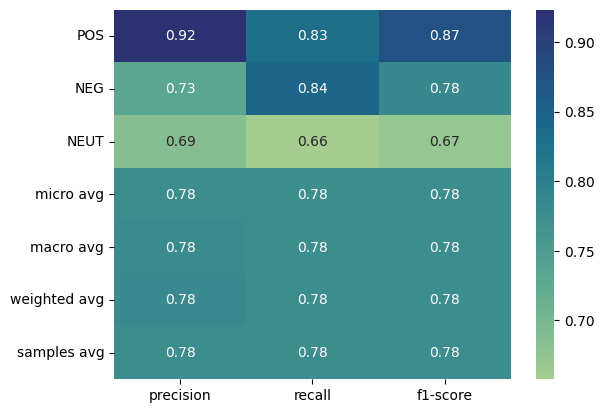

In [ ]:
y_pred_OH = argmaxKeepDimensions(y_pred.logits)
accuray = accuracy_score(y_pred_OH, y_test_bert_OH)

report = classification_report(y_test_bert_OH, y_pred_OH, target_names=['POS', 'NEG', 'NEUT'], output_dict=True)
sb.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='crest')

print("Accuracy:", accuray)

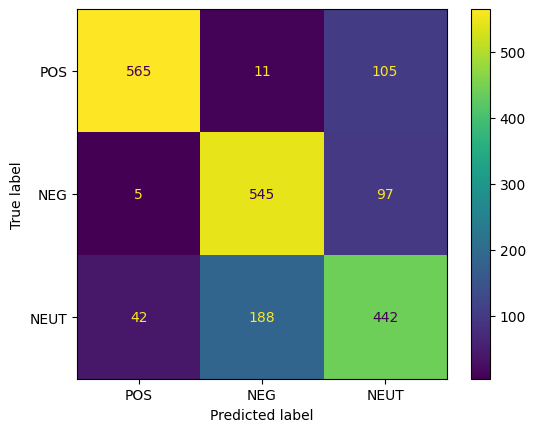

In [ ]:
labels = [0,1,2]
cm = confusion_matrix(np.argmax(y_test_bert_OH, axis=1), np.argmax(y_pred_OH, axis=1), labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['POS', 'NEG', 'NEUT'])
disp.plot();

## **Bert as Embedding layer**

In [ ]:
transformer_model = TFBertModel.from_pretrained('bert-base-uncased')
transformer_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
input_token_type = tf.keras.layers.Input(shape=(128,), name='token_type', dtype='int32')
X = transformer_model(input_ids, input_masks_ids,input_token_type)[0]
#X = tf.keras.layers.LSTM(128)(X)
X = tf.keras.layers.Flatten()(X)
d1 = Dense(128, activation='relu')(X)
d1 = Dropout(0.2)(d1)
d1 = BatchNormalization()(d1)

'''d2 = Dense(128, activation='relu')(input2)
d2 = Dropout(0.2)(d2)
d2 = BatchNormalization()(d2)

c = Concatenate()([d1, d2])'''

d = Dense(64, activation='relu')(d1)
d = Dropout(0.2)(d)
d = BatchNormalization()(d)

output = Dense(3, activation="softmax")(d)
X = tf.keras.layers.Dense(3, activation='softmax')(X)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids,input_token_type], outputs = X)

In [ ]:
filepath = basePath + 'bertEMBD.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
y_train_bert_OH.shape

(6000, 3)

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit([token_ids_train, attention_masks_train, token_type_ids_train], y_train_bert_OH, validation_data=([token_ids_dev, attention_masks_dev, token_type_ids_dev], y_dev_bert_OH), epochs=5, batch_size=64, verbose=1,callbacks=[checkpoint]).history

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 [==============================] - 98s 826ms/step - loss: 16.9957 - accuracy: 0.6222 - val_loss: 9.6550 - val_accuracy: 0.6805
Epoch 2/5
94/94 [==============================] - 68s 729ms/step - loss: 5.8638 - accuracy: 0.7830 - val_loss: 17.1275 - val_accuracy: 0.6340
Epoch 3/5
94/94 [==============================] - 72s 771ms/step - loss: 5.4147 - accuracy: 0.8238 - val_loss: 17.2714 - val_accuracy: 0.6130
Epoch 4/5
94/94 [==============================] - 79s 846ms/step - loss: 2.5446 - accuracy: 0.8927 - val_loss: 14.6735 - val_accuracy: 0.6885
Epoch 5/5
94/94 [==============================] - 79s 839ms/step - loss: 1.7585 - accuracy: 0.9225 - val_loss: 13.4237 - val_accuracy: 0.6975


In [ ]:
#model = load_model(basePath+'/Models/'+'Bert_W.h5')
os.makedirs(os.path.dirname(basePath+'/Models/'), exist_ok=True)
model.save_weights(basePath+'/Models/'+'Bert_W.h5')

In [ ]:
filepath = basePath + 'bertEMBD.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

transformer_model.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()
model.load_weights(basePath+'/Models/'+'Bert_W.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 token_type (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_token[0][0]',            
                                thPoolingAndCrossAt               'masked_token[0][0]',       

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit([token_ids_train, attention_masks_train, token_type_ids_train], y_train_bert_OH, validation_data=([token_ids_dev, attention_masks_dev, token_type_ids_dev], y_dev_bert_OH), epochs=5, batch_size=64, verbose=1, callbacks=[checkpoint]).history

Epoch 1/5


94/94 [==============================] - 225s 2s/step - loss: 1.1277 - accuracy: 0.9458 - val_loss: 11.6689 - val_accuracy: 0.7290
Epoch 2/5
94/94 [==============================] - 161s 2s/step - loss: 0.7027 - accuracy: 0.9605 - val_loss: 12.9697 - val_accuracy: 0.7115
Epoch 3/5
94/94 [==============================] - 159s 2s/step - loss: 0.2371 - accuracy: 0.9808 - val_loss: 10.9318 - val_accuracy: 0.7200
Epoch 4/5
94/94 [==============================] - 175s 2s/step - loss: 0.2927 - accuracy: 0.9772 - val_loss: 11.1687 - val_accuracy: 0.7340
Epoch 5/5
94/94 [==============================] - 167s 2s/step - loss: 0.1292 - accuracy: 0.9888 - val_loss: 10.3691 - val_accuracy: 0.7400


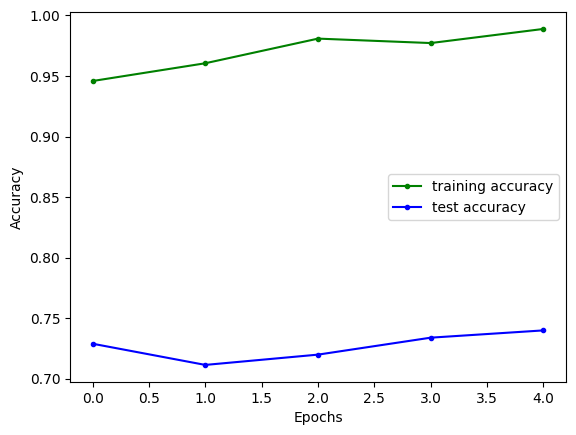

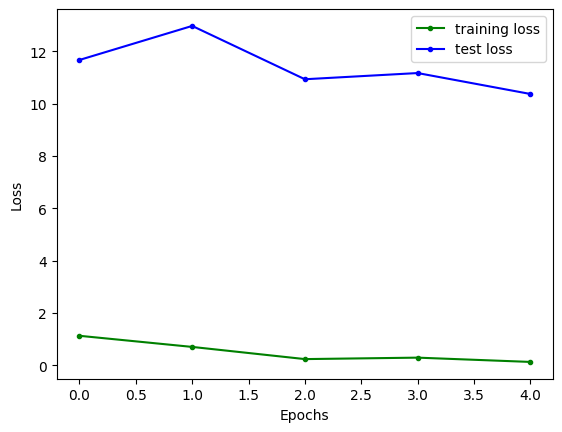

In [ ]:
 showPlots(history)

In [ ]:
with tf.device('/GPU:0'):
  display(model.evaluate([token_ids_test, attention_masks_test, token_type_ids_test], y_test_bert_OH, verbose=0))
  y_pred = model.predict([token_ids_test, attention_masks_test, token_type_ids_test])

[10.888700485229492, 0.7289999723434448]

63/63 [==============================] - 17s 273ms/step


Accuracy: 0.729


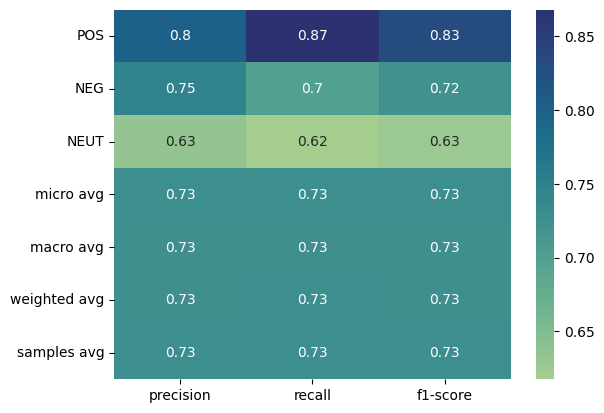

In [ ]:
y_pred_OH = argmaxKeepDimensions(y_pred)
accuray = accuracy_score(y_pred_OH, y_test_bert_OH)

report = classification_report(y_test_bert_OH, y_pred_OH, target_names=['POS', 'NEG', 'NEUT'], output_dict=True)
sb.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='crest')

print("Accuracy:", accuray)

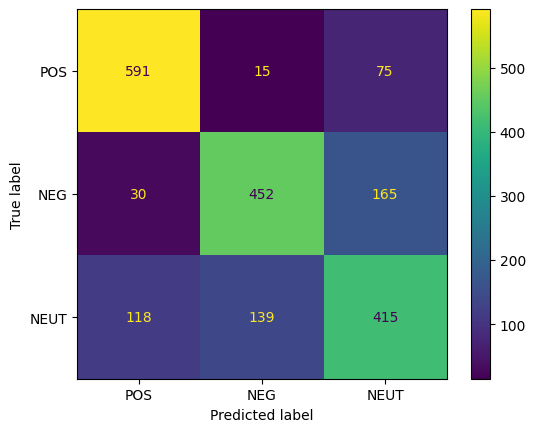

In [ ]:
labels = [0,1,2]
cm = confusion_matrix(np.argmax(y_test_bert_OH, axis=1), np.argmax(y_pred_OH, axis=1), labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['POS', 'NEG', 'NEUT'])
disp.plot();

# **Helper**

In [ ]:
# delete samples which their body or headline is empty

def deleteSomeIndicesFromList(a, indices):
  a = a.copy()
  for index in sorted(indices, reverse=True):
    a.pop(index)
  return a

indices = [i for i, x in enumerate(review_body_encoded) if len(x)==0]
indices = indices + [i for i, x in enumerate(review_headline_encoded) if len(x)==0]
indices = np.unique(indices)

print('index of samples which their body or headline are empty: ', indices)

review_body_dropped = deleteSomeIndicesFromList(review_body_encoded, indices)
review_headline_dropped = deleteSomeIndicesFromList(review_headline_encoded, indices)
rev_class_dropped = deleteSomeIndicesFromList(rev_class, indices)

len(review_body_dropped), len(review_headline_dropped), len(rev_class_dropped)

index of samples which their body or headline are empty:  [  1514   1632   1830 ... 952604 955484 956398]


(958554, 958554, 958554)